In [1]:
#chrome://dino/

In [2]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

In [3]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [4]:
class Env(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 380, 'left': 630, 'width': 660, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

# Testing Environment

In [5]:
env = Env()

In [6]:
obs=env.get_observation()

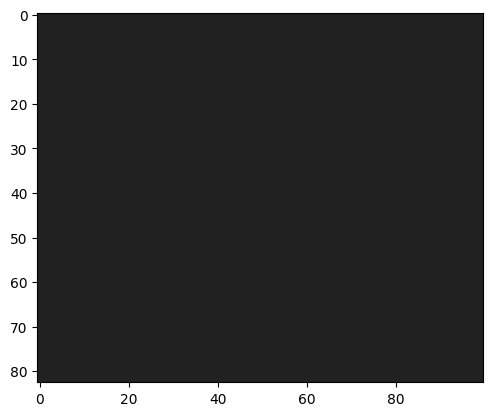

In [7]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [8]:
done, done_cap = env.get_done()

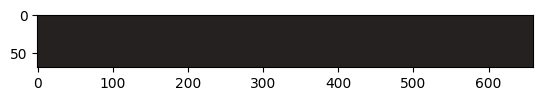

In [9]:
plt.imshow(done_cap)

In [10]:
pytesseract.image_to_string(done_cap)[:4]

''

In [11]:
done

False

In [12]:
# for episode in range(10): 
#     obs = env.reset()
#     done = False  
#     total_reward   = 0
#     while not done: 
#         obs, reward,  done, info =  env.step(env.action_space.sample())
#         total_reward  += reward
#     print('Total Reward for episode {} is {}'.format(episode, total_reward))    

In [13]:
import os 
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [14]:
env_checker.check_env(env)

In [15]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [16]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [17]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [18]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [19]:
env =  Env()

In [20]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\praka\.conda\envs\rl\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 2.65GB
  warnings.warn(


In [21]:
model.learn(total_timesteps=100, callback=callback)

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.2     |
|    ep_rew_mean      | 15.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 28       |
|    total_timesteps  | 61       |
----------------------------------


In [22]:
model.load('best_model') 

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.zip'

# 4. Test out Model

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)